<a href="https://colab.research.google.com/github/remember0834/exchange-rate-prediction-/blob/main/%ED%99%98%EC%9C%A8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_%EA%B5%AC%EC%B6%95%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 수집 시작...

환율: 1236개
금리: 1827개


/tmp/ipython-input-253840008.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = exchange.merge(rate, on='date', how='left').fillna(method='ffill')
/tmp/ipython-input-253840008.py:54: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-253840008.py:54: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-253840008.py:54: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-253840008.py:54: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-253840008.py:54: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-253840008.py:54: User

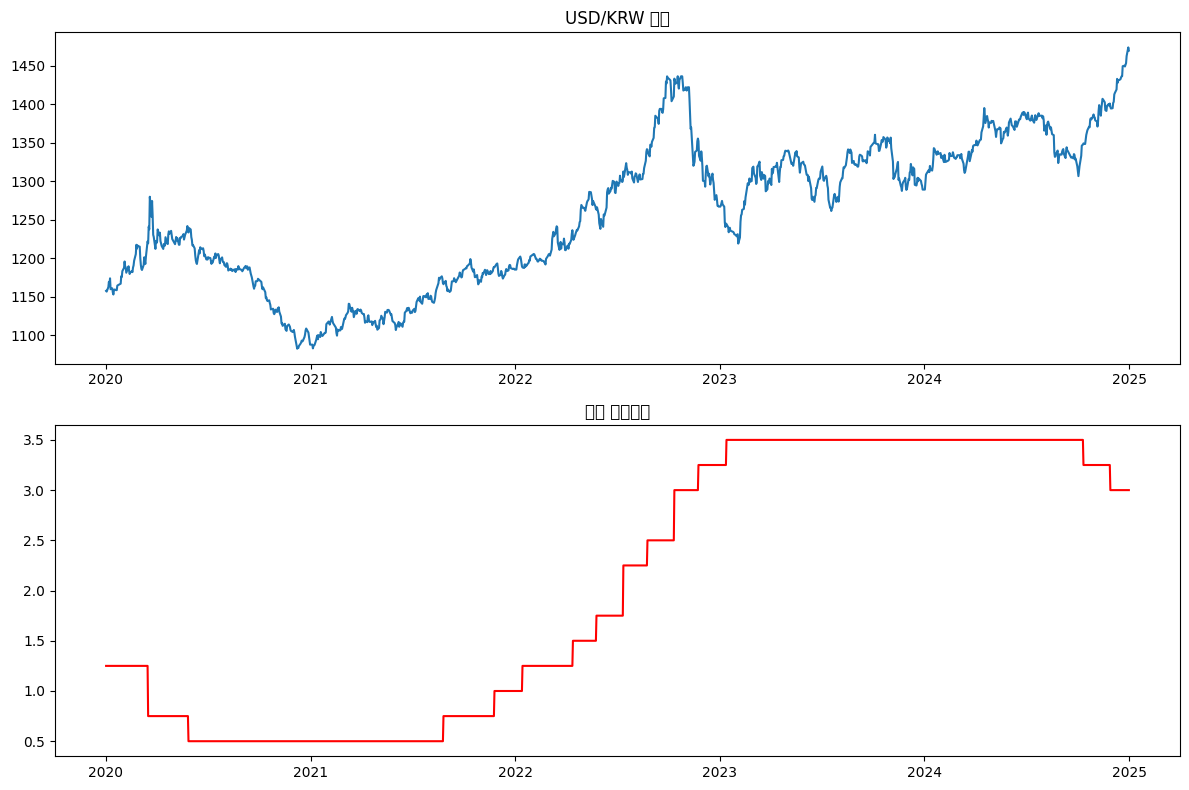


저장 완료: 1236행


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# ============================================
# 한국은행 API - 완전 통합 버전
# ============================================
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
from google.colab import files

# API 키 설정
API_KEY = "Q34XMPWKWKAW2VC92NSR"  # 실제 키로 변경!
BASE_URL = "https://ecos.bok.or.kr/api"

# 함수 정의
def get_bok_data(api_key, stat_code, start_date, end_date, item_code, col_name):
    """범용 한국은행 데이터 수집"""
    url = f"{BASE_URL}/StatisticSearch/{api_key}/json/kr/1/100000/{stat_code}/D/{start_date}/{end_date}/{item_code}"

    try:
        response = requests.get(url, timeout=30)
        data = response.json()

        if 'StatisticSearch' in data:
            rows = data['StatisticSearch']['row']
            return pd.DataFrame([{
                'date': pd.to_datetime(row['TIME']),
                col_name: float(row['DATA_VALUE'])
            } for row in rows]).sort_values('date').reset_index(drop=True)
    except:
        pass

    return pd.DataFrame()

# 데이터 수집
print("데이터 수집 시작...\n")

exchange = get_bok_data(API_KEY, "731Y001", "20200101", "20241231", "0000001", "usd_krw")
print(f"환율: {len(exchange)}개")

time.sleep(2)

rate = get_bok_data(API_KEY, "722Y001", "20200101", "20241231", "0101000", "kr_base_rate")
print(f"금리: {len(rate)}개")

# 통합
merged = exchange.merge(rate, on='date', how='left').fillna(method='ffill')

# 시각화
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(merged['date'], merged['usd_krw'])
ax[0].set_title('USD/KRW 환율')
ax[1].plot(merged['date'], merged['kr_base_rate'], color='red')
ax[1].set_title('한국 기준금리')
plt.tight_layout()
plt.show()

# 저장 및 다운로드
merged.to_csv("bok_api_data.csv", index=False, encoding='utf-8-sig')
print(f"\n저장 완료: {len(merged)}행")

files.download("bok_api_data.csv")


In [4]:
import yfinance as yf
import pandas as pd

# 미국 10년 국채 수익률
us_rate = yf.download("^TNX", start="2020-01-01", end="2024-12-31")

# DataFrame 변환 (올바른 방법)
us_rate_df = pd.DataFrame({
    'date': us_rate.index,
    'us_base_rate': us_rate['Close'].values.flatten()  # flatten() 추가
})

# 또는 이렇게 (더 간단)
us_rate_df = us_rate[['Close']].reset_index()
us_rate_df.columns = ['date', 'us_base_rate']

print(f"미국 금리 데이터: {len(us_rate_df)}개")
print(us_rate_df.head())

# 기존 한국은행 데이터 로드
bok_data = pd.read_csv("bok_api_data.csv", parse_dates=['date'])

# 병합
merged = bok_data.merge(us_rate_df, on='date', how='left')

# 결측치 처리 (전방 채우기)
merged['us_base_rate'] = merged['us_base_rate'].fillna(method='ffill')

# 금리차 계산
merged['rate_diff'] = merged['kr_base_rate'] - merged['us_base_rate']

print(f"\n통합 완료: {len(merged)}행 × {len(merged.columns)}열")
print("\n최근 5일:")
print(merged.tail())

# 저장
merged.to_csv("teamA_exchange_rates.csv", index=False, encoding='utf-8-sig')

print("\n저장 완료: teamA_exchange_rates.csv")

# 다운로드 (Colab)
from google.colab import files
files.download("teamA_exchange_rates.csv")

/tmp/ipython-input-1246306325.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  us_rate = yf.download("^TNX", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

미국 금리 데이터: 1257개
        date  us_base_rate
0 2020-01-02         1.882
1 2020-01-03         1.788
2 2020-01-06         1.811
3 2020-01-07         1.827
4 2020-01-08         1.874

통합 완료: 1236행 × 5열

최근 5일:
           date  usd_krw  kr_base_rate  us_base_rate  rate_diff
1231 2024-12-24   1449.3           3.0         4.591     -1.591
1232 2024-12-26   1453.6           3.0         4.579     -1.579
1233 2024-12-27   1462.9           3.0         4.619     -1.619
1234 2024-12-30   1474.1           3.0         4.545     -1.545
1235 2024-12-31   1470.0           3.0         4.545     -1.545

저장 완료: teamA_exchange_rates.csv



/tmp/ipython-input-1246306325.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['us_base_rate'] = merged['us_base_rate'].fillna(method='ffill')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

팀원 B: 주요 지수 데이터 수집 시작

[1/3] 달러인덱스 (DXY) 수집 중...


/tmp/ipython-input-2300804301.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy_raw = yf.download("DX-Y.NYB", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


✓ DXY 수집 완료: 1257개
  범위: 89.44 ~ 114.11

최근 5일:
           date         dxy
1252 2024-12-23  108.040001
1253 2024-12-24  108.260002
1254 2024-12-26  108.129997
1255 2024-12-27  108.000000
1256 2024-12-30  108.129997

[2/3] 코스피 지수 수집 중...


/tmp/ipython-input-2300804301.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  kospi_raw = yf.download("^KS11", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


✓ KOSPI 수집 완료: 1229개
  범위: 1457.64 ~ 3305.21

최근 5일:
           date        kospi
1224 2024-12-23  2442.010010
1225 2024-12-24  2440.520020
1226 2024-12-26  2429.669922
1227 2024-12-27  2404.770020
1228 2024-12-30  2399.489990

[3/3] S&P 500 지수 수집 중...


/tmp/ipython-input-2300804301.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_raw = yf.download("^GSPC", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2300804301.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2300804301.py:148: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2300804301.py:148: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2300804301.py:148: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2300804301.py:148: UserWarning: Glyph 45937 (\N{HANGUL S

✓ S&P500 수집 완료: 1257개
  범위: 2237.40 ~ 6090.27

최근 5일:
           date        sp500
1252 2024-12-23  5974.069824
1253 2024-12-24  6040.040039
1254 2024-12-26  6037.589844
1255 2024-12-27  5970.839844
1256 2024-12-30  5906.939941

데이터 통합 중...
통합 완료: 1297행 × 4열

파생 변수 생성 중...
✓ 파생 변수 생성 완료

데이터 품질 확인

결측치:
date                 0
dxy                  0
kospi                0
sp500                0
dxy_return           1
kospi_return         1
sp500_return         1
kospi_ma20          19
sp500_ma20          19
kospi_volatility    19
dtype: int64

기초 통계:
               dxy        kospi        sp500
count  1297.000000  1297.000000  1297.000000
mean     99.985914  2596.823977  4258.617295
std       5.750807   337.070379   765.312015
min      89.440002  1457.640015  2237.399902
25%      94.250000  2399.489990  3819.719971
50%     101.550003  2572.090088  4204.109863
75%     104.309998  2757.090088  4604.370117
max     114.110001  3305.209961  6090.270020

주요 지수 간 상관계수:
         dxy  kospi  sp5

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

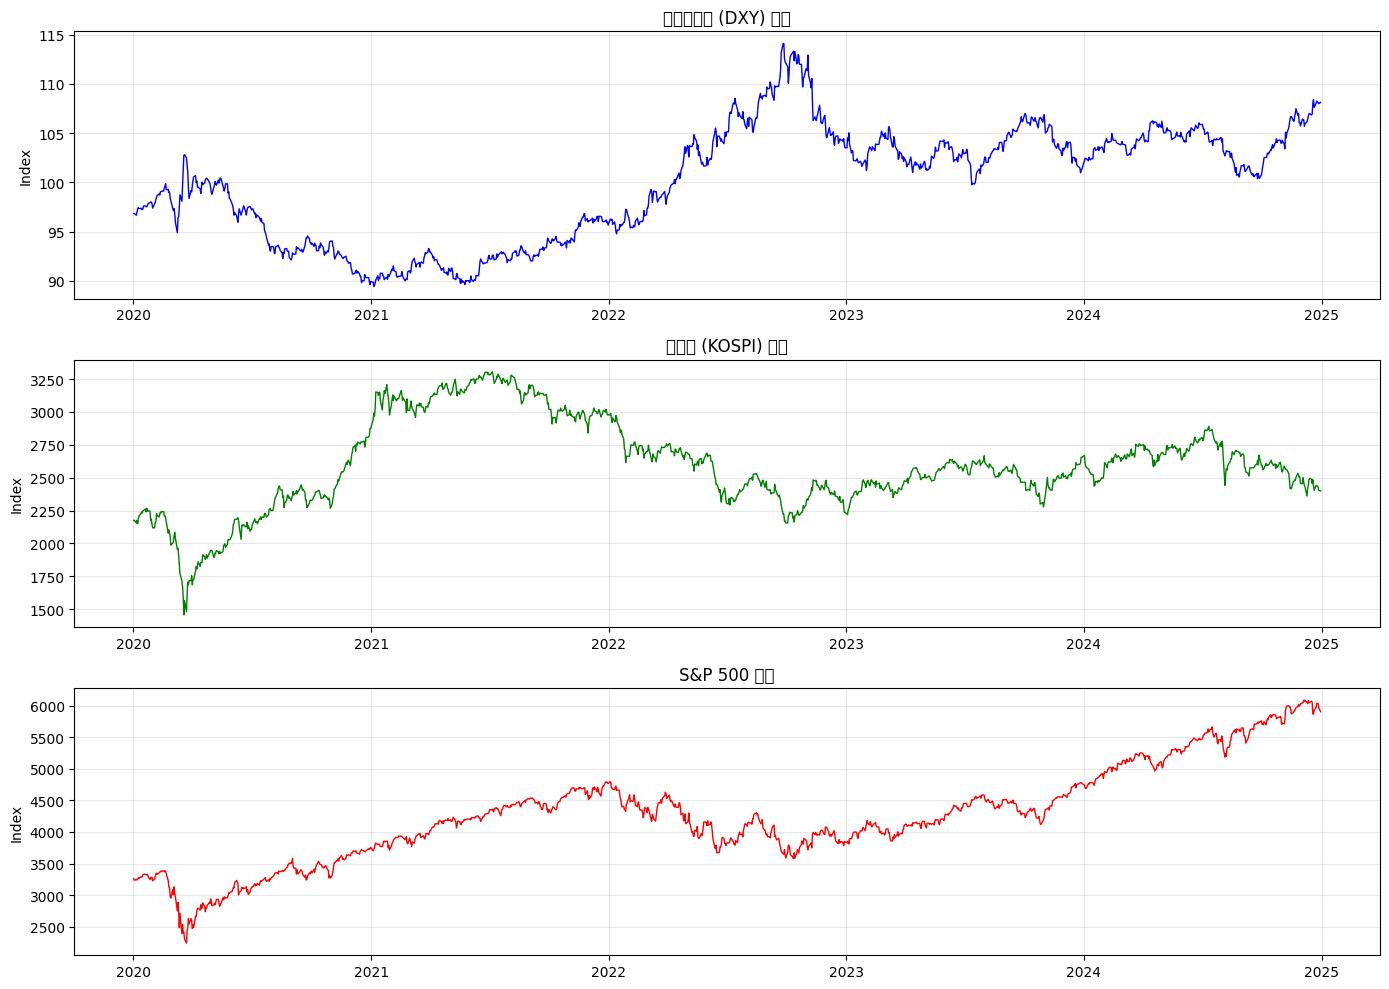


CSV 파일 저장

저장 완료: teamB_indices.csv
크기: 1297행 × 10열

최종 데이터 미리보기 (최근 10일):
           date         dxy        kospi        sp500  kospi_return
1287 2024-12-16  106.860001  2488.969971  6074.080078     -0.002201
1288 2024-12-17  106.959999  2456.810059  6050.609863     -0.012921
1289 2024-12-18  108.029999  2484.429932  5872.160156      0.011242
1290 2024-12-19  108.410004  2435.929932  5867.080078     -0.019522
1291 2024-12-20  107.620003  2404.149902  5930.850098     -0.013046
1292 2024-12-23  108.040001  2442.010010  5974.069824      0.015748
1293 2024-12-24  108.260002  2440.520020  6040.040039     -0.000610
1294 2024-12-26  108.129997  2429.669922  6037.589844     -0.004446
1295 2024-12-27  108.000000  2404.770020  5970.839844     -0.010248
1296 2024-12-30  108.129997  2399.489990  5906.939941     -0.002196


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


팀원 B 작업 완료!
생성 파일: teamB_indices.csv
다음: 팀원 A 파일과 통합


In [5]:
"""
팀원 B: 주요 지수 데이터 수집
- DXY (달러인덱스)
- KOSPI (코스피)
- S&P500
"""

import yfinance as yf
import pandas as pd
import time

print("="*70)
print("팀원 B: 주요 지수 데이터 수집 시작")
print("="*70)

# ============================================
# 1. 달러인덱스 (DXY)
# ============================================
print("\n[1/3] 달러인덱스 (DXY) 수집 중...")

dxy_raw = yf.download("DX-Y.NYB", start="2020-01-01", end="2024-12-31")

dxy_df = dxy_raw[['Close']].reset_index()
dxy_df.columns = ['date', 'dxy']

print(f"✓ DXY 수집 완료: {len(dxy_df)}개")
print(f"  범위: {dxy_df['dxy'].min():.2f} ~ {dxy_df['dxy'].max():.2f}")
print(f"\n최근 5일:")
print(dxy_df.tail())

time.sleep(1)  # API 부하 방지

# ============================================
# 2. 코스피 (KOSPI)
# ============================================
print("\n[2/3] 코스피 지수 수집 중...")

kospi_raw = yf.download("^KS11", start="2020-01-01", end="2024-12-31")

kospi_df = kospi_raw[['Close']].reset_index()
kospi_df.columns = ['date', 'kospi']

print(f"✓ KOSPI 수집 완료: {len(kospi_df)}개")
print(f"  범위: {kospi_df['kospi'].min():.2f} ~ {kospi_df['kospi'].max():.2f}")
print(f"\n최근 5일:")
print(kospi_df.tail())

time.sleep(1)

# ============================================
# 3. S&P 500
# ============================================
print("\n[3/3] S&P 500 지수 수집 중...")

sp500_raw = yf.download("^GSPC", start="2020-01-01", end="2024-12-31")

sp500_df = sp500_raw[['Close']].reset_index()
sp500_df.columns = ['date', 'sp500']

print(f"✓ S&P500 수집 완료: {len(sp500_df)}개")
print(f"  범위: {sp500_df['sp500'].min():.2f} ~ {sp500_df['sp500'].max():.2f}")
print(f"\n최근 5일:")
print(sp500_df.tail())

# ============================================
# 4. 데이터 통합
# ============================================
print("\n" + "="*70)
print("데이터 통합 중...")
print("="*70)

# 모든 지수 병합
merged = dxy_df.merge(kospi_df, on='date', how='outer')
merged = merged.merge(sp500_df, on='date', how='outer')

# 날짜 순 정렬
merged = merged.sort_values('date').reset_index(drop=True)

# 결측치 처리
merged = merged.fillna(method='ffill').fillna(method='bfill')

print(f"통합 완료: {len(merged)}행 × {len(merged.columns)}열")

# ============================================
# 5. 수익률 계산 (파생 변수)
# ============================================
print("\n파생 변수 생성 중...")

# 일일 수익률 계산
merged['dxy_return'] = merged['dxy'].pct_change()
merged['kospi_return'] = merged['kospi'].pct_change()
merged['sp500_return'] = merged['sp500'].pct_change()

# 이동평균 (20일)
merged['kospi_ma20'] = merged['kospi'].rolling(window=20).mean()
merged['sp500_ma20'] = merged['sp500'].rolling(window=20).mean()

# 변동성 (20일)
merged['kospi_volatility'] = merged['kospi'].rolling(window=20).std()

print("✓ 파생 변수 생성 완료")

# ============================================
# 6. 데이터 확인
# ============================================
print("\n" + "="*70)
print("데이터 품질 확인")
print("="*70)

# 결측치
print(f"\n결측치:")
print(merged.isnull().sum())

# 기초 통계
print(f"\n기초 통계:")
print(merged[['dxy', 'kospi', 'sp500']].describe())

# 상관관계
print(f"\n주요 지수 간 상관계수:")
corr = merged[['dxy', 'kospi', 'sp500']].corr()
print(corr.round(3))

# ============================================
# 7. 시각화
# ============================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# DXY
axes[0].plot(merged['date'], merged['dxy'], linewidth=1, color='blue')
axes[0].set_title('달러인덱스 (DXY) 추이', fontsize=12)
axes[0].set_ylabel('Index', fontsize=10)
axes[0].grid(True, alpha=0.3)

# KOSPI
axes[1].plot(merged['date'], merged['kospi'], linewidth=1, color='green')
axes[1].set_title('코스피 (KOSPI) 추이', fontsize=12)
axes[1].set_ylabel('Index', fontsize=10)
axes[1].grid(True, alpha=0.3)

# S&P500
axes[2].plot(merged['date'], merged['sp500'], linewidth=1, color='red')
axes[2].set_title('S&P 500 추이', fontsize=12)
axes[2].set_ylabel('Index', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 8. CSV 저장 및 다운로드
# ============================================
print("\n" + "="*70)
print("CSV 파일 저장")
print("="*70)

output_file = "teamB_indices.csv"
merged.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n저장 완료: {output_file}")
print(f"크기: {len(merged)}행 × {len(merged.columns)}열")

# 최종 데이터 미리보기
print("\n최종 데이터 미리보기 (최근 10일):")
print(merged[['date', 'dxy', 'kospi', 'sp500', 'kospi_return']].tail(10))

# Colab에서 다운로드
from google.colab import files
files.download(output_file)

print("\n" + "="*70)
print("팀원 B 작업 완료!")
print("="*70)
print(f"생성 파일: {output_file}")
print("다음: 팀원 A 파일과 통합")

팀원 C: 상품 및 리스크 지표 수집 시작

[1/3] WTI 원유 가격 수집 중...


/tmp/ipython-input-798742637.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  wti_raw = yf.download("CL=F", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


✓ WTI 수집 완료: 1257개
  범위: $-37.63 ~ $123.70

최근 5일:
           date        wti
1252 2024-12-23  69.239998
1253 2024-12-24  70.099998
1254 2024-12-26  69.620003
1255 2024-12-27  70.599998
1256 2024-12-30  70.989998

[2/3] VIX 공포지수 수집 중...


/tmp/ipython-input-798742637.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download("^VIX", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


✓ VIX 수집 완료: 1257개
  범위: 11.86 ~ 82.69

최근 5일:
           date        vix
1252 2024-12-23  16.780001
1253 2024-12-24  14.270000
1254 2024-12-26  14.730000
1255 2024-12-27  15.950000
1256 2024-12-30  17.400000

2020년 3월 최대 VIX: 82.69 (코로나 패닉)

[3/3] 금 가격 수집 중...


/tmp/ipython-input-798742637.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_raw = yf.download("GC=F", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-798742637.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE 

✓ Gold 수집 완료: 1257개
  범위: $1477.30 ~ $2788.50

최근 5일:
           date         gold
1252 2024-12-23  2612.300049
1253 2024-12-24  2620.000000
1254 2024-12-26  2638.800049
1255 2024-12-27  2617.199951
1256 2024-12-30  2606.100098

데이터 통합 중...
통합 완료: 1257행 × 4열

파생 변수 생성 중...
✓ 파생 변수 생성 완료

데이터 품질 확인

결측치:
date               0
wti                0
vix                0
gold               0
wti_return         1
gold_return        1
vix_change         1
wti_ma20          19
gold_ma20         19
wti_volatility    19
dtype: int64

기초 통계:
               wti          vix         gold
count  1257.000000  1257.000000  1257.000000
mean     70.972633    21.415163  1940.163005
std      20.198475     8.264239   265.857055
min     -37.630001    11.860000  1477.300049
25%      62.700001    15.920000  1777.500000
50%      73.790001    19.660000  1869.699951
75%      81.910004    24.860001  1988.400024
max     123.699997    82.690002  2788.500000

주요 지표 간 상관계수:
        wti    vix   gold
wti   1.000 -0.364

/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-798742637.py:159: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout

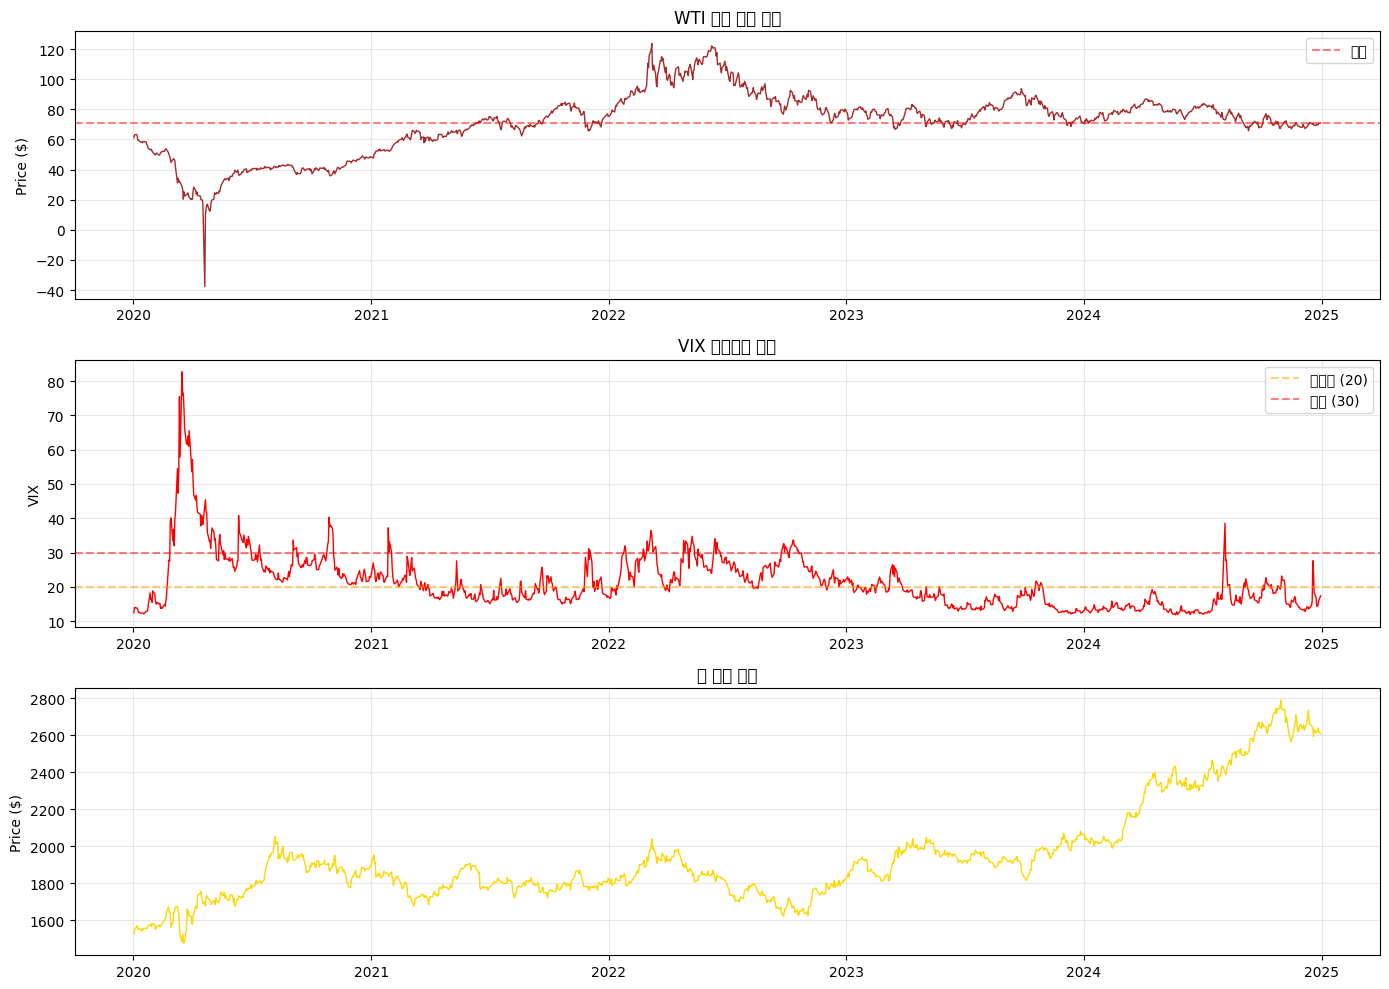


주요 사건 분석

VIX 30 이상 고위험 기간: 135일
주요 날짜:
         date        vix        wti         gold
38 2020-02-27  39.160000  47.090000  1640.000000
39 2020-02-28  40.110001  44.759998  1564.099976
40 2020-03-02  33.419998  46.750000  1592.300049
41 2020-03-03  36.820000  47.180000  1642.099976
42 2020-03-04  31.990000  46.779999  1641.099976
43 2020-03-05  39.619999  45.900002  1666.400024
44 2020-03-06  41.939999  41.279999  1670.800049
45 2020-03-09  54.459999  31.129999  1674.500000
46 2020-03-10  47.299999  34.360001  1659.099976
47 2020-03-11  53.900002  32.980000  1641.400024

유가 5% 이상 급변동: 81일

CSV 파일 저장

저장 완료: teamC_commodities_risk.csv
크기: 1257행 × 10열

최종 데이터 미리보기 (최근 10일):
           date        wti        vix         gold  wti_return
1247 2024-12-16  70.709999  14.690000  2651.399902   -0.008136
1248 2024-12-17  70.080002  15.870000  2644.399902   -0.008910
1249 2024-12-18  70.580002  27.620001  2636.500000    0.007135
1250 2024-12-19  69.910004  24.090000  2592.199951   -0.009493
1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


팀원 C 작업 완료!
생성 파일: teamC_commodities_risk.csv
다음: 팀원 A, B, C 파일 전체 통합


In [6]:
"""
팀원 C: 상품 및 리스크 지표 데이터 수집
- WTI (원유)
- VIX (공포지수)
- Gold (금)
"""

import yfinance as yf
import pandas as pd
import time

print("="*70)
print("팀원 C: 상품 및 리스크 지표 수집 시작")
print("="*70)

# ============================================
# 1. WTI 원유 가격
# ============================================
print("\n[1/3] WTI 원유 가격 수집 중...")

wti_raw = yf.download("CL=F", start="2020-01-01", end="2024-12-31")

wti_df = wti_raw[['Close']].reset_index()
wti_df.columns = ['date', 'wti']

print(f"✓ WTI 수집 완료: {len(wti_df)}개")
print(f"  범위: ${wti_df['wti'].min():.2f} ~ ${wti_df['wti'].max():.2f}")
print(f"\n최근 5일:")
print(wti_df.tail())

time.sleep(1)

# ============================================
# 2. VIX 공포지수
# ============================================
print("\n[2/3] VIX 공포지수 수집 중...")

vix_raw = yf.download("^VIX", start="2020-01-01", end="2024-12-31")

vix_df = vix_raw[['Close']].reset_index()
vix_df.columns = ['date', 'vix']

print(f"✓ VIX 수집 완료: {len(vix_df)}개")
print(f"  범위: {vix_df['vix'].min():.2f} ~ {vix_df['vix'].max():.2f}")
print(f"\n최근 5일:")
print(vix_df.tail())

# 2020년 3월 코로나 시기 확인
covid_period = vix_df[(vix_df['date'] >= '2020-03-01') & (vix_df['date'] <= '2020-03-31')]
print(f"\n2020년 3월 최대 VIX: {covid_period['vix'].max():.2f} (코로나 패닉)")

time.sleep(1)

# ============================================
# 3. 금 가격
# ============================================
print("\n[3/3] 금 가격 수집 중...")

gold_raw = yf.download("GC=F", start="2020-01-01", end="2024-12-31")

gold_df = gold_raw[['Close']].reset_index()
gold_df.columns = ['date', 'gold']

print(f"✓ Gold 수집 완료: {len(gold_df)}개")
print(f"  범위: ${gold_df['gold'].min():.2f} ~ ${gold_df['gold'].max():.2f}")
print(f"\n최근 5일:")
print(gold_df.tail())

# ============================================
# 4. 데이터 통합
# ============================================
print("\n" + "="*70)
print("데이터 통합 중...")
print("="*70)

# 모든 상품 데이터 병합
merged = wti_df.merge(vix_df, on='date', how='outer')
merged = merged.merge(gold_df, on='date', how='outer')

# 날짜 순 정렬
merged = merged.sort_values('date').reset_index(drop=True)

# 결측치 처리
merged = merged.fillna(method='ffill').fillna(method='bfill')

print(f"통합 완료: {len(merged)}행 × {len(merged.columns)}열")

# ============================================
# 5. 파생 변수 생성
# ============================================
print("\n파생 변수 생성 중...")

# 일일 수익률
merged['wti_return'] = merged['wti'].pct_change()
merged['gold_return'] = merged['gold'].pct_change()

# VIX 변화량
merged['vix_change'] = merged['vix'].diff()

# 이동평균
merged['wti_ma20'] = merged['wti'].rolling(window=20).mean()
merged['gold_ma20'] = merged['gold'].rolling(window=20).mean()

# 변동성
merged['wti_volatility'] = merged['wti'].rolling(window=20).std()

print("✓ 파생 변수 생성 완료")

# ============================================
# 6. 데이터 품질 확인
# ============================================
print("\n" + "="*70)
print("데이터 품질 확인")
print("="*70)

# 결측치
print(f"\n결측치:")
print(merged.isnull().sum())

# 기초 통계
print(f"\n기초 통계:")
print(merged[['wti', 'vix', 'gold']].describe())

# 상관관계
print(f"\n주요 지표 간 상관계수:")
corr = merged[['wti', 'vix', 'gold']].corr()
print(corr.round(3))

# ============================================
# 7. 시각화
# ============================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# WTI
axes[0].plot(merged['date'], merged['wti'], linewidth=1, color='brown')
axes[0].set_title('WTI 원유 가격 추이', fontsize=12)
axes[0].set_ylabel('Price ($)', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=merged['wti'].mean(), color='red', linestyle='--', alpha=0.5, label='평균')
axes[0].legend()

# VIX
axes[1].plot(merged['date'], merged['vix'], linewidth=1, color='red')
axes[1].set_title('VIX 공포지수 추이', fontsize=12)
axes[1].set_ylabel('VIX', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='경계선 (20)')
axes[1].axhline(y=30, color='red', linestyle='--', alpha=0.5, label='공포 (30)')
axes[1].legend()

# Gold
axes[2].plot(merged['date'], merged['gold'], linewidth=1, color='gold')
axes[2].set_title('금 가격 추이', fontsize=12)
axes[2].set_ylabel('Price ($)', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 8. 특이 사건 분석
# ============================================
print("\n" + "="*70)
print("주요 사건 분석")
print("="*70)

# VIX 30 이상인 고위험 기간
high_risk = merged[merged['vix'] > 30]
print(f"\nVIX 30 이상 고위험 기간: {len(high_risk)}일")
print("주요 날짜:")
print(high_risk[['date', 'vix', 'wti', 'gold']].head(10))

# 유가 급등/급락
wti_extreme = merged[abs(merged['wti_return']) > 0.05]
print(f"\n유가 5% 이상 급변동: {len(wti_extreme)}일")

# ============================================
# 9. CSV 저장 및 다운로드
# ============================================
print("\n" + "="*70)
print("CSV 파일 저장")
print("="*70)

output_file = "teamC_commodities_risk.csv"
merged.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n저장 완료: {output_file}")
print(f"크기: {len(merged)}행 × {len(merged.columns)}열")

# 최종 데이터 미리보기
print("\n최종 데이터 미리보기 (최근 10일):")
print(merged[['date', 'wti', 'vix', 'gold', 'wti_return']].tail(10))

# Colab에서 다운로드
from google.colab import files
files.download(output_file)

print("\n" + "="*70)
print("팀원 C 작업 완료!")
print("="*70)
print(f"생성 파일: {output_file}")
print("다음: 팀원 A, B, C 파일 전체 통합")

최종 데이터셋 생성 - 전체 통합

[1/5] 데이터 로드 중...
팀원 A (환율+금리): 1236행 × 5열
팀원 B (지수): 1297행 × 10열
팀원 C (상품+리스크): 1257행 × 10열

[2/5] 데이터 통합 중...
통합 완료: 1298행 × 23열

통합 후 결측치:
date                 0
usd_krw             62
kr_base_rate        62
us_base_rate        62
rate_diff           62
dxy                  1
kospi                1
sp500                1
dxy_return           2
kospi_return         2
sp500_return         2
kospi_ma20          20
sp500_ma20          20
kospi_volatility    20
wti                 41
vix                 41
gold                41
wti_return          42
gold_return         42
vix_change          42
wti_ma20            60
gold_ma20           60
wti_volatility      60
dtype: int64

[3/5] 결측치 처리 중...
결측치 처리 후:
date                0
usd_krw             0
kr_base_rate        0
us_base_rate        0
rate_diff           0
dxy                 0
kospi               0
sp500               0
dxy_return          0
kospi_return        0
sp500_return        0
kospi_ma20          0
sp5

/tmp/ipython-input-4197845368.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/tmp/ipython-input-4197845368.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
/tmp/ipython-input-4197845368.py:186: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4197845368.py:186: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4197845368.py:186: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4197845368.py:186: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython

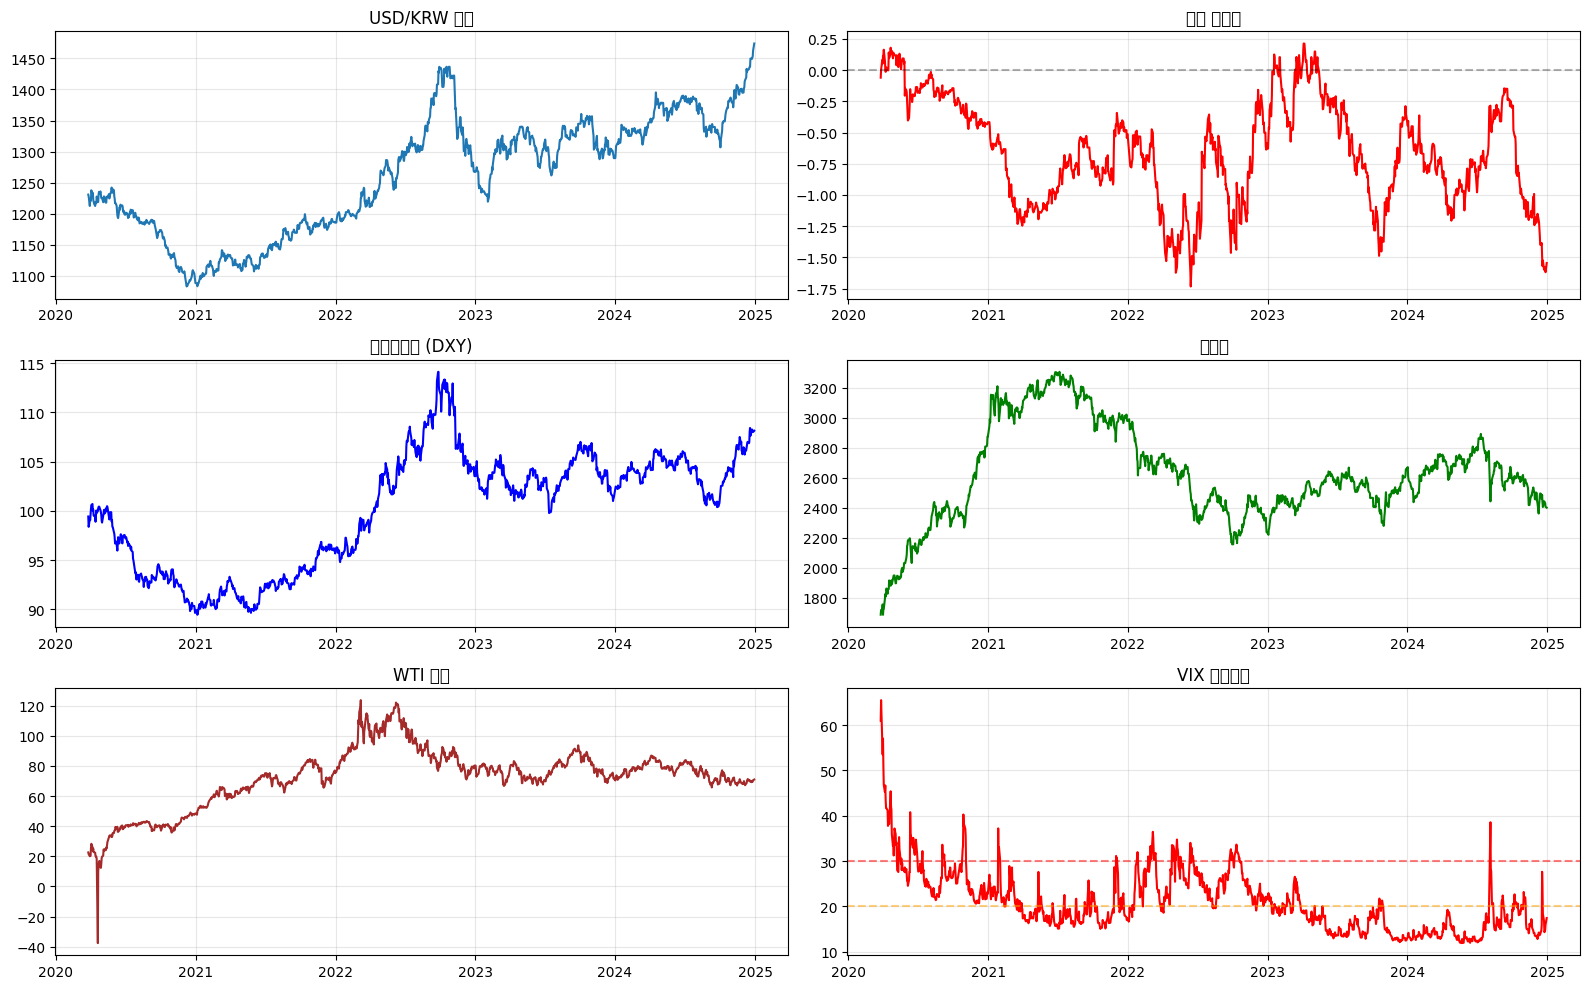


CSV 파일 저장

저장 완료: final_exchange_dataset.csv
최종 크기: 1,237행 × 34열

최종 데이터셋 요약 보고서

파일명: final_exchange_dataset.csv
데이터 기간: 2020-03-26 ~ 2024-12-30
총 데이터 포인트: 1,237개
총 변수 개수: 34개

데이터 미리보기 (최근 5일):
           date  usd_krw  rate_diff         dxy        kospi        wti  \
1292 2024-12-23   1450.3     -1.599  108.040001  2442.010010  69.239998   
1293 2024-12-24   1449.3     -1.591  108.260002  2440.520020  70.099998   
1294 2024-12-26   1453.6     -1.579  108.129997  2429.669922  69.620003   
1295 2024-12-27   1462.9     -1.619  108.000000  2404.770020  70.599998   
1296 2024-12-30   1474.1     -1.545  108.129997  2399.489990  70.989998   

            vix  target_next_day  
1292  16.780001           1449.3  
1293  14.270000           1453.6  
1294  14.730000           1462.9  
1295  15.950000           1474.1  
1296  17.400000           1470.0  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


전체 데이터 통합 완료!
다음 단계: 모델링 및 분석


In [7]:
"""
최종 데이터셋 생성: 팀원 A, B, C 데이터 통합
+ Feature Engineering
"""

import pandas as pd
import numpy as np

print("="*70)
print("최종 데이터셋 생성 - 전체 통합")
print("="*70)

# ============================================
# 1. 각 팀원 데이터 로드
# ============================================
print("\n[1/5] 데이터 로드 중...")

teamA = pd.read_csv("teamA_exchange_rates.csv", parse_dates=['date'])
teamB = pd.read_csv("teamB_indices.csv", parse_dates=['date'])
teamC = pd.read_csv("teamC_commodities_risk.csv", parse_dates=['date'])

print(f"팀원 A (환율+금리): {len(teamA)}행 × {len(teamA.columns)}열")
print(f"팀원 B (지수): {len(teamB)}행 × {len(teamB.columns)}열")
print(f"팀원 C (상품+리스크): {len(teamC)}행 × {len(teamC.columns)}열")

# ============================================
# 2. 데이터 통합
# ============================================
print("\n[2/5] 데이터 통합 중...")

# outer join으로 모든 날짜 포함
df = teamA.merge(teamB, on='date', how='outer')
df = df.merge(teamC, on='date', how='outer')

# 날짜 순 정렬
df = df.sort_values('date').reset_index(drop=True)

print(f"통합 완료: {len(df)}행 × {len(df.columns)}열")

# 결측치 확인
print("\n통합 후 결측치:")
print(df.isnull().sum())

# ============================================
# 3. 결측치 처리
# ============================================
print("\n[3/5] 결측치 처리 중...")

# Forward fill (전일 값으로 채우기)
df = df.fillna(method='ffill')

# Backward fill (시작 부분)
df = df.fillna(method='bfill')

# 선형 보간 (남은 결측치)
df = df.interpolate(method='linear')

print("결측치 처리 후:")
print(df.isnull().sum())

# ============================================
# 4. 추가 Feature Engineering
# ============================================
print("\n[4/5] 추가 Feature Engineering...")

# 환율 시차 변수
df['usd_krw_lag1'] = df['usd_krw'].shift(1)
df['usd_krw_lag7'] = df['usd_krw'].shift(7)
df['usd_krw_lag30'] = df['usd_krw'].shift(30)

# 환율 이동평균
df['usd_krw_ma5'] = df['usd_krw'].rolling(window=5).mean()
df['usd_krw_ma20'] = df['usd_krw'].rolling(window=20).mean()
df['usd_krw_ma60'] = df['usd_krw'].rolling(window=60).mean()

# 환율 변동성
df['usd_krw_volatility'] = df['usd_krw'].rolling(window=20).std()

# 환율 / 이동평균 비율
df['usd_krw_to_ma20'] = df['usd_krw'] / df['usd_krw_ma20']

# 환율 수익률
df['usd_krw_return'] = df['usd_krw'].pct_change()

# 타겟 변수 (예측 목표)
df['target_next_day'] = df['usd_krw'].shift(-1)
df['target_direction'] = (df['target_next_day'] > df['usd_krw']).astype(int)

print("✓ Feature Engineering 완료")

# ============================================
# 5. 데이터 정제
# ============================================
print("\n[5/5] 최종 데이터 정제...")

# 처음 60일 제거 (이동평균 계산으로 인한 결측)
df_clean = df.iloc[60:].copy()

# 마지막 1일 제거 (타겟 변수 생성으로 인한 결측)
df_clean = df_clean.iloc[:-1].copy()

# 남은 결측치 제거
df_clean = df_clean.dropna()

print(f"정제 완료: {len(df_clean)}행 × {len(df_clean.columns)}열")

# ============================================
# 6. 데이터 품질 검증
# ============================================
print("\n" + "="*70)
print("데이터 품질 검증")
print("="*70)

print(f"\n기본 정보:")
print(f"  기간: {df_clean['date'].min().date()} ~ {df_clean['date'].max().date()}")
print(f"  총 데이터: {len(df_clean):,}개")
print(f"  총 변수: {len(df_clean.columns)}개")
print(f"  결측치: {df_clean.isnull().sum().sum()}개")

print(f"\n변수 구성:")
print(f"  기본 변수: date, usd_krw, kr_base_rate, us_base_rate, rate_diff")
print(f"  지수: dxy, kospi, sp500")
print(f"  상품/리스크: wti, vix, gold")
print(f"  파생 변수: 수익률, 이동평균, 변동성, 시차 등")
print(f"  타겟 변수: target_next_day, target_direction")

print(f"\n주요 변수 범위:")
print(f"  USD/KRW: {df_clean['usd_krw'].min():.2f} ~ {df_clean['usd_krw'].max():.2f}원")
print(f"  금리차: {df_clean['rate_diff'].min():.2f} ~ {df_clean['rate_diff'].max():.2f}%")
print(f"  DXY: {df_clean['dxy'].min():.2f} ~ {df_clean['dxy'].max():.2f}")
print(f"  KOSPI: {df_clean['kospi'].min():.2f} ~ {df_clean['kospi'].max():.2f}")
print(f"  VIX: {df_clean['vix'].min():.2f} ~ {df_clean['vix'].max():.2f}")

# ============================================
# 7. 상관관계 분석
# ============================================
print("\n환율과 주요 변수 간 상관계수:")
correlation_vars = ['rate_diff', 'dxy', 'kospi', 'sp500', 'wti', 'vix']
correlations = df_clean[['usd_krw'] + correlation_vars].corr()['usd_krw'].sort_values(ascending=False)

for var, corr in correlations.items():
    if var != 'usd_krw':
        print(f"  {var:15s}: {corr:6.3f}")

# ============================================
# 8. 시각화
# ============================================
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10))

# 2x3 그리드
ax1 = plt.subplot(3, 2, 1)
ax1.plot(df_clean['date'], df_clean['usd_krw'])
ax1.set_title('USD/KRW 환율')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 2, 2)
ax2.plot(df_clean['date'], df_clean['rate_diff'], color='red')
ax2.set_title('한미 금리차')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(3, 2, 3)
ax3.plot(df_clean['date'], df_clean['dxy'], color='blue')
ax3.set_title('달러인덱스 (DXY)')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(3, 2, 4)
ax4.plot(df_clean['date'], df_clean['kospi'], color='green')
ax4.set_title('코스피')
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 2, 5)
ax5.plot(df_clean['date'], df_clean['wti'], color='brown')
ax5.set_title('WTI 원유')
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 2, 6)
ax6.plot(df_clean['date'], df_clean['vix'], color='red')
ax6.set_title('VIX 공포지수')
ax6.axhline(y=20, color='orange', linestyle='--', alpha=0.5)
ax6.axhline(y=30, color='red', linestyle='--', alpha=0.5)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 9. 컬럼 순서 정리 및 저장
# ============================================
print("\n" + "="*70)
print("CSV 파일 저장")
print("="*70)

# 컬럼 순서 재배열
core_cols = ['date', 'usd_krw', 'kr_base_rate', 'us_base_rate', 'rate_diff']
index_cols = ['dxy', 'kospi', 'sp500']
commodity_cols = ['wti', 'vix', 'gold']

# 파생 변수들
lag_cols = [col for col in df_clean.columns if 'lag' in col]
ma_cols = [col for col in df_clean.columns if 'ma' in col and 'usd_krw' in col]
vol_cols = [col for col in df_clean.columns if 'volatility' in col]
return_cols = [col for col in df_clean.columns if 'return' in col]
other_derived = [col for col in df_clean.columns if col not in core_cols + index_cols + commodity_cols + lag_cols + ma_cols + vol_cols + return_cols and col not in ['target_next_day', 'target_direction']]

# 타겟 변수는 마지막
target_cols = ['target_next_day', 'target_direction']

# 최종 순서
final_cols = core_cols + index_cols + commodity_cols + lag_cols + ma_cols + vol_cols + return_cols + other_derived + target_cols
final_cols = [col for col in final_cols if col in df_clean.columns]

df_final = df_clean[final_cols]

# 저장
output_file = "final_exchange_dataset.csv"
df_final.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n저장 완료: {output_file}")
print(f"최종 크기: {len(df_final):,}행 × {len(df_final.columns)}열")

# ============================================
# 10. 최종 요약 보고서
# ============================================
print("\n" + "="*70)
print("최종 데이터셋 요약 보고서")
print("="*70)

print(f"\n파일명: {output_file}")
print(f"데이터 기간: {df_final['date'].min().date()} ~ {df_final['date'].max().date()}")
print(f"총 데이터 포인트: {len(df_final):,}개")
print(f"총 변수 개수: {len(df_final.columns)}개")

print(f"\n데이터 미리보기 (최근 5일):")
preview_cols = ['date', 'usd_krw', 'rate_diff', 'dxy', 'kospi', 'wti', 'vix', 'target_next_day']
print(df_final[preview_cols].tail())

# Colab에서 다운로드
from google.colab import files
files.download(output_file)

print("\n" + "="*70)
print("전체 데이터 통합 완료!")
print("="*70)
print("다음 단계: 모델링 및 분석")